# DQMC (Determinant Quantum Monte-Carlo) 
Last edited, June 2022
by Mr. Song Menghan


Any suggestions and bugs, [send an email to me](mailto:songmh@connect.hku.hk).

This is a sample code for simulating square lattice Hubbard model using DQMC. The notebook is written with the reference of Dr. Bin Bin Chen, Mr. Li Chuhao and Mr. Hongyu Lu. 

For detailed analytical derivation, please check [the note written by Mr. Gaopei Pan](https://quantummc.xyz/2020/10/11/dqmc-note/). 


Here is another nice note which outlines the algorithm written by Richard T. Scalettar in UCD, [a note written by Prof. Scalettar](https://scalettar.physics.ucdavis.edu/michigan/howto1.pdf). 


### Hamiltonian & Partition function


Use square-lattice Hubbard model as an example here. 


The half-filling Hamiltonian is (we consider $U>0$, the repulsive interaction here): $$H=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.+U\mathop{\sum}\limits_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})=H_T+H_V.$$

With the Trotter decomposition, 
$$
\begin{equation}
    e^{-\varDelta\tau H} = e^{-\varDelta\tau H_V}e^{-\varDelta\tau H_T} + O[(\varDelta\tau)^2]
\end{equation}
$$
the partition function is written as  $$Tr\{e^{-\beta H}\}=Tr\{(e^{-\Delta\tau H})^{L_\tau}\}$$

The kinetic part involves two fermion operators, i.e. it is a quadratic form. And in it, the sum for spin-up and spin-down are the same and for example it can be expressed as :
$$ H_V = \sum_{i} H_U$$
$$H_0=c^\dagger_\uparrow T c_\uparrow=-t\mathop{\sum}\limits_{<i,j>}c_{i\uparrow}^\dagger c_{j\uparrow}+h.c. $$ 

However, the interaction term has four fermion operators in it, i.e. non quadratic.It can be expressed as :
$$H_U=U\mathop (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})=-\frac{U}{2}(n_\uparrow-n_\downarrow)^2+\frac{U}{4}$$For details, check [PhysRevB.7.432](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.7.432/).  
We can do HS transformation to write it into a quadratic form: $$e^{-\Delta\tau H_U}=\gamma\sum_{s=\pm 1}e^{\alpha s(n_\uparrow-n_\downarrow)},$$ with $\gamma=\frac{1}{2}e^{-\Delta\tau U/4}$, and $\cosh(\alpha)=e^{\Delta\tau U/2}$.

Therefore, the expanded partition function is:
$$Z=\sum_{s_{i, l}=\pm 1}\gamma^{NL_\tau}Tr_F\{ \prod_{l=1}^{L_\tau}[(\prod_ie^{\alpha s_{i,l}n_{i\uparrow}})(e^{-\Delta\tau c_\uparrow^\dagger T c_\uparrow})(\prod_ie^{-\alpha s_{i,l}n_{i\downarrow}})(e^{-\Delta\tau c_\downarrow^\dagger T c_\downarrow}) ]\}\\ =\gamma^{NL_\tau}\sum_{s_{i,l}}\prod_{\sigma=\uparrow\downarrow}Det[I+B^\sigma(L_\tau\Delta\tau,(L_\tau-1)\Delta\tau)\dots B^\sigma(\Delta\tau,0)]$$
where $B^{\sigma=\uparrow,\downarrow}(l_2\Delta\tau,l_1\Delta\tau)=\prod_{l=l_1+1}^{l_2}e^{\alpha Diag(\vec S_l)}e^{-\Delta\tau T}$ and Diag($\vec S_l$) is a diagonal matrix with the diagonal elements being $s_{i,l}$.



### Turn trace into determinant

We have successfully transform the original Hamiltonian into a form in whcih all terms are quadratic. The reason we do this is that when computing the trace of a quadratic form of fermion operator on the exponent like $e^{c^\dagger A c}$, we can always convert it into a determinant. Mathematically,

$$
\begin{equation}
\operatorname{Tr}\left[e^{-\sum_{i, j} \hat{c}_{i}^{\dagger} A_{i, j} \hat{c}_{j}}\right]=\operatorname{Det}\left[\mathbf{1}+e^{-\mathbf{A}}\right].
\end{equation}
$$

The proof and generalization could be found at [the 2nd part of The Note by Mr. Pan](https://quantummc.xyz/dqmc-note/part-2-starting-from-hubbard-model/). 

$$
\begin{equation}\operatorname{Tr}\left[e^{-\sum_{i, j} c_{i}^{\dagger} A_{i, j} c_{j}} e^{-\sum_{i, j} c_{i}^{\dagger} B_{i, j} c_{j}}\right]=\operatorname{Det}\left[\mathbf{1}+e^{-\mathbf{A}} e^{-\mathbf{B}}\right]\end{equation}
$$

The $\mathbf{A}$ and the $\mathbf{B}$ here could be regarded as $\mathbf{H_K}$ and the $\mathbf{H_V}$ in the Hamiltonian.

In [1]:
import numpy as np
import sys
import scipy
from scipy import linalg
import os

### The kinetic matrix


$$H_K=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}.$$

Here the $<i,j>$ represents the nearest neighbour interaction, and $\sigma = \uparrow, \downarrow$ represent the spin up and down. We write the term into its matrix form.

$$
-t \sum_{<ij>} (c^\dagger_{i\uparrow} c_{j\uparrow} + c^{\dagger}_{j\uparrow}c_{i\uparrow}) = \boldsymbol{c}_\uparrow^\dagger T \boldsymbol{c}_\uparrow
$$

Matrix $T$ contains an element $-t$ at position $(i,j)$ if row i and column j are nearest neighbours and elements $-\mu$ on diagonal. The following code is to compute the kinetic matrix, $T$. ($\mu$ is set to zero for half-fill case and letter $K$ replacing $T$ for the kinetic matrix)

In [2]:
def cart_coord(i,Lx): # i is the site index starts from 1.
    ix = i % Lx     
    iy = i//Lx + 1
    if i % Lx == 0: 
        iy -= 1
        ix = Lx
    return ix,iy

def linear_index(ix,iy,Lx):  #output linear index starts from 1.
    return int((iy-1)*Lx+ix)


def Neighbor(index,Lx,Ly):
    ix,iy=cart_coord(index,Lx)
    up_y = iy - 1
    if up_y <1:
        up_y=Ly
    up = linear_index(ix,up_y,Lx)
    
    down_y = iy+1
    if down_y > Ly:
        down_y = 1
    down=linear_index(ix,down_y,Lx)
    
    left_x=ix-1
    if left_x < 1:
        left_x = Lx
    left = linear_index(left_x,iy,Lx)
    
    right_x = ix+1
    if right_x > Lx:
        right_x = 1
    right = linear_index(right_x,iy,Lx)
    return up,down,left,right

def gen_auxf(MatDim,N_time_slice):
    auxf = np.zeros((MatDim,N_time_slice),dtype=int)
    for i in range(MatDim):
        for j in range(N_time_slice):
            auxf[i][j]= int(2*int(2*np.random.random())-1)
    return auxf

def K(Lx,Ly,t):
    MatDim = Lx*Ly
    N_pc = Lx*Ly
    K_mat = np.zeros((MatDim,MatDim))
    for i in range(N_pc):
        down = Neighbor(i+1,Lx,Ly)[1]-1
        right = Neighbor(i+1,Lx,Ly)[3]-1
        K_mat[i][down]-=t
        K_mat[down][i]-=t
        K_mat[i][right]-=t
        K_mat[right][i]-=t
    return K_mat


In [3]:
K(2,2,t=1),K(3,3,t=1)

(array([[ 0., -2., -2.,  0.],
        [-2.,  0.,  0., -2.],
        [-2.,  0.,  0., -2.],
        [ 0., -2., -2.,  0.]]),
 array([[ 0., -1., -1., -1.,  0.,  0., -1.,  0.,  0.],
        [-1.,  0., -1.,  0., -1.,  0.,  0., -1.,  0.],
        [-1., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  0., -1.,  0., -1.,  0.],
        [ 0.,  0., -1., -1., -1.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0., -1.,  0.,  0.,  0., -1., -1.],
        [ 0., -1.,  0.,  0., -1.,  0., -1.,  0., -1.],
        [ 0.,  0., -1.,  0.,  0., -1., -1., -1.,  0.]]))

Note that for the non-interacting case (U =0), 
$$
H_K=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}.
$$
We have the single-particle eigenenergy,
$$
\varepsilon_k = -2t(\cos k_x+\cos k_y).
$$

This is nothing but the eigenenergy of the tight binding Hamiltonian with the nearest neighbour interaction. We can plot this band and the fermi-surfaces. For a half-filled band, the fermi-surface is a diamond. For more theoretic analysis of Hubbard model, please check [PhysRevB.31.4403](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.4403). 

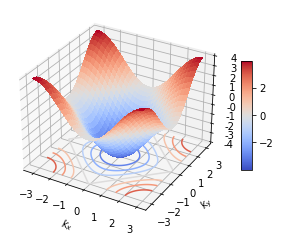

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-np.pi, np.pi, 0.1)
Y = np.arange(-np.pi, np.pi, 0.1)

X, Y = np.meshgrid(X, Y)
Z = -2*(np.cos(X)+np.cos(Y))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-4, cmap=cm.coolwarm)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


### Interaction part

We have defined the $B$ matrix which occurs in the trace,


$$
B_\tau^\sigma = B^{\sigma}(\tau \varDelta\tau,(\tau-1) \varDelta\tau) = e^{\alpha S_l} e^{-\varDelta\tau T}
$$


Below is to compute the $e^{\alpha S_l}$ term in the $B_\tau^\sigma$. Since $S_l$ is a diagonal matrix with HS field value $+1 or -1$ at diagonal. The matrix $e^{\alpha S_l}$ is also diagonal. For convinience, we store all the diagonal elements for a time slice $l$ into the $l^{th}$ column of an $N$ by $L$ matrix, $N$ is the total sites, $L$ is the imaginary time length.

In [5]:
def ExpV(S,spin,alpha):
    '''Construct the length-N vector exp(spin*alpha*S(:,l)) for every spin
    Each length N vector stands for a diagonal matrix of size N-by-N
    There are totally L such matrices.
    For efficiency, store information for all L matrices in one N-by-L 2D
    array. Each column represents a different diagonal matrix expV
    Args: 
        S = (N,L) matrix, current H-S field configuration
        spin = 1 or -1, representing up or down spin
        alpha
    Outputs:
        (N,L) matrix storing exp(V(l,spin)) data'''
    
    if spin!=-1 and spin!=1:
        print('spin value must be +1 or -1!!!')
        sys.exit()
    else:
        Diags = np.exp(S*spin*alpha)
        return Diags
    
    
    

Below is an optional step with higher order Trotter decomposition to wrap the Green function for higher precision.

In [6]:
def Half_Wrap(GF,Expdt_HalfK,InvExpdt_HalfK):
    '''Produce symmetric Trotter decomp version of GF from asymmetric version
    Args:
        G, unwrapped GF matrix used in simulation
        Expdt_HalfK, exp(dt*KMatrix/2)
        InvExpdt_HalfK, exp(-dt*KMatrix/2)
    Outputs:
        (N,N) wrapped GF matrix'''
    GF=np.dot(np.dot(Expdt_HalfK,GF),InvExpdt_HalfK)
    return GF

The 'circshift' function is used to shift the columns in the $N\times L$ matrix, returned by $ExpV()$. If we apply $circshift(\tau)$ to the $ExpV()$, the first column of the $ExpV()$ matrix displays the diagonal elements of $e^{\alpha S_{\tau+1}}$. Then we can conveniently obtain $B(\tau, 0) B(\beta, \tau) $ for any $\tau\in \left [  0,\beta\right ] $ following the same computing procedure.

In [7]:
def circshift(u,shiftnum1,shiftnum2):
    '''shift the row or column of a matrix
    shiftnum1: shift row
    shiftnum2: shift column
    +:up to down, left to right
    -:down to up, right to left'''
    h,w = u.shape
    if shiftnum1 < 0:
        u = np.vstack((u[-shiftnum1:,:],u[:-shiftnum1,:]))
    else:
        u = np.vstack((u[(h-shiftnum1):,:],u[:(h-shiftnum1),:]))
    if shiftnum2 > 0:
        u = np.hstack((u[:, (w - shiftnum2):], u[:, :(w - shiftnum2)]))
    else:
        u = np.hstack((u[:,-shiftnum2:],u[:,:-shiftnum2]))
    return u


### Numerical stabilization

See [the 4th part of The Note by Mr. Pan](https://quantummc.xyz/dqmc-note/part-4-numerical-stability-and-sign-problem/) for details.

Using pivot QR decomposition to compute the Green function.


$$
\begin{equation}
G(\tau, \tau)=[\mathbf{1}+B(\tau, 0) B(\beta, \tau)]^{-1} 
\end{equation}
$$


Different from the way in the note in which we decompose $B(\tau, 0)$ and $B(\beta, \tau)$ seperately, here we compute the $B(\tau, 0) B(\beta, \tau)$ as a whole. $B(\tau, 0) B(\beta, \tau)$ is a $L$ matrices product string. For convenience, we do not QR decompose each $B(\tau,\tau+\delta\tau)$ matrix here, but decompose a number of $B$ matrices (BatchSize) directly multipy together.

The pivot QR decoomposition does the following, 
$$
\begin{equation}
B(...) = QRP^{-1} = QDD^{-1}RP^{-1}=QDT
\end{equation}
$$
where $T\equiv D^{-1}RP^{-1}$, $D=diag(abs(R))$ is a diagonal matrix, $P$ is a permutation matrix that permutes the column of the preceding one. In code, $RP^{-1}$ is computed as 'R[:,InvP]' and 'InvP = P.argsort()'.

In [8]:
def MakeGMatrix_QR(ExpVData,InvExpdtK,LShift,BatchSize):
    '''Calculate equal-time green function matrix from scratch using Pivote
    -QR to stablize the simulation
    Args:
        ExpVData:  N-by-L 2D matrix, V matrix data (depends on current H-S field)
                    Each column is exp(spin*lmbd*S(:,l))
        InvExpdtK: inverse of exp(dt*KMatrix)
                   i.e. exp(-dt*KMatrix)
        LShift:    Account for change in GF definition after l wraps
               e.g. 0 means no wraping
        BatchSize: Number of B matrices to directly multiply together.
               e.g. 10 for a typical safe value
    Outputs:
        GF: N-by-N equal-time GF matrix
        Sign: +1 or -1, sign of determinant of this GF matrix
    '''
    N,L=np.shape(ExpVData)
    #shift the column of expV matrix to left, so that we deal with the l-th
    #Im time in the 1-st column of expV.
    ExpVData = circshift(ExpVData,0,-LShift)
    # divide into batches to reduce number of QR decomposition we have to do
    if np.mod(L,BatchSize)!=0:
        print('BatchSize and L do not suit!!!')
        sys.exit()
    NumBatches = int(L/BatchSize)
    
    BMats = np.zeros([NumBatches,N,N])
    # form every batch by normal matrix multiplication
    for jj in range(NumBatches):
        Datajj = ExpVData[:,jj*BatchSize:(jj+1)*BatchSize]
        BMat = np.eye(N)
        # form B((jj+1)*b)*...*B(jj*b) by multiplying right to left
        for ll in range(np.shape(Datajj)[1]):
            BMat = np.dot(np.dot(InvExpdtK,np.diag(Datajj[:,ll])),BMat)
        BMats[jj,:,:]=BMat
    #Now! go through BMats and calculate matrix products
    # N.B.!, to increase numerical stability, use three output, [Q,R,Perm] to
    # trigger pivoting QR
    Q,R,P = scipy.linalg.qr(BMats[0,:,:], pivoting=True)
    InvP = P.argsort()
    D = np.abs(np.diag(R))
    T = np.dot(np.diag(1/D),R[:,InvP])
    
    
    for ll in range(1,NumBatches):
        # ll-th B matrix Batch
        C = np.dot(np.dot(BMats[ll,:,:],Q),np.diag(D))
        Q,R,P = scipy.linalg.qr(C, pivoting=True)
        InvP = P.argsort()
        D = np.abs(np.diag(R))
        T = np.dot(np.dot(np.diag(1/D),R[:,InvP]),T)
    
    # Post Processing
    # elementwise product, Db*Ds=D
    Db = D.copy()
    Ds = D.copy()
    for x in range(np.shape(D)[0]):
        if Db[x]<1:
            Db[x]=1
        if Ds[x]>1:
            Ds[x]=1
   
    #results
    lft = np.linalg.inv(np.dot(np.diag(1/Db),Q.T)+np.dot(np.diag(Ds),T))
    rgt = np.dot(np.diag(1/Db),Q.T)
    GF = np.dot(lft,rgt)
    
     
    Extra = np.dot(Q.T,(np.dot(np.diag(1/Db),Q.T)+np.dot(np.diag(Ds),T)))
    DetExtra = np.linalg.det(Extra)
    Sign = np.sign(DetExtra)
    return GF,Sign

### Structure factor

We can measure the staggered structure factor at $Q=(\pi,\pi)$ $$S(\pi,\pi)=\frac{1}{N}\sum_{ij}e^{-i\textbf{Q}=(\pi,\pi))(\textbf{r}_i-\textbf{r}_j)}\langle s_i^zs_j^z\rangle=\frac{1}{4N}\sum_{ij}(-)^{i-j}(\langle n_{i\uparrow}n_{j\uparrow} \rangle+\langle n_{i\downarrow}n_{j\downarrow} \rangle-\langle n_{i\uparrow}n_{j\downarrow} \rangle-\langle n_{i\downarrow}n_{j\uparrow} \rangle), $$
where $s_i^z=\frac{1}{2}(n_{i\uparrow}-n_{i\downarrow})$, $(-)^{i-j}$ is $+1$ if i and j are on the same sublattice, but $-1$ if not. $\frac{1}{2}$ here is to normalize the $S_z$ component to $\pm1/2$. There is a $N$ at the denominator because we sum up the correlation observed at each site as a reference point. (Note that a different definition of $S(Q)$ may not include $N$ at the denominator, in that case one only measures the correlation at a fixed site, $i$.) 

From Wick's theorem

$\langle n_{i\uparrow}n_{j\uparrow}\rangle = (1-G_{\uparrow}(i,i))(1-G_{\uparrow}(j,j))+(\delta_{i,j}-G_{\uparrow}(j,i))(G_{\uparrow}(i,j))$, $\delta_{i,j}=0$ if $i\ne j$ and $\delta_{i,j}=1$ if $i= j$

$\langle n_{i\uparrow}n_{j\downarrow}\rangle = \langle n_{i\uparrow}\rangle \langle n_{j\downarrow}\rangle = (1-G_{\uparrow}(i,i))(1-G_{\downarrow}(j,j))$

, where we also use the anticommutation relation of fermion operators $\left \{ c_{i\sigma}^\dagger c_{j\sigma^{'}} \right \}= \delta_{ij}\delta_{\sigma \sigma^{'}}$.

Below is to define the sublattice to determine the value of $(-)^{i-j}$

In [9]:
def MakeSublattice(Lx,Ly):
    N_pc=Lx*Ly
    sub_A=np.zeros(int(N_pc/2))
    sub_B=np.zeros(int(N_pc/2))
    sub_indexa=0
    sub_indexb=0
    for subix in range(Lx):
        for subiy in range(Ly):
            if np.mod(subix+subiy+1,2)==0:
                sub_A[sub_indexa]=subix+subiy*Ly
                sub_indexa=sub_indexa+1
            else:
                sub_B[sub_indexb]=subix+subiy*Ly
                sub_indexb=sub_indexb+1
    return sub_A, sub_B

In [10]:
A,B = MakeSublattice(4,4)
A,B

(array([ 4., 12.,  1.,  9.,  6., 14.,  3., 11.]),
 array([ 0.,  8.,  5., 13.,  2., 10.,  7., 15.]))

Here we compute the $S(\pi,\pi)$

In [11]:
def Getspipi(Lx,Ly,Gup00,Gdn00):
    spipi=0
    sub_A, sub_B = MakeSublattice(Lx,Ly)
    N_pc=Lx*Ly
    for i in range(N_pc):
        for j in range(N_pc):
            if i==j:
                kro=1
            else:
                kro=0
            if (i in sub_A)==(j in sub_A) or (i in sub_B)==(j in sub_B):
                spipi+=(1-Gup00[i,i])*(1-Gup00[j,j])+(kro-Gup00[j,i])*Gup00[i,j]+(1-Gdn00[i,i])*(1-Gdn00[j,j])+(kro-Gdn00[j,i])*Gdn00[i,j]-(1-Gup00[i,i])*(1-Gdn00[j,j])-(1-Gdn00[i,i])*(1-Gup00[j,j])
            else:
                spipi-=(1-Gup00[i,i])*(1-Gup00[j,j])+(kro-Gup00[j,i])*Gup00[i,j]+(1-Gdn00[i,i])*(1-Gdn00[j,j])+(kro-Gdn00[j,i])*Gdn00[i,j]-(1-Gup00[i,i])*(1-Gdn00[j,j])-(1-Gdn00[i,i])*(1-Gup00[j,j])
    spipi = spipi/(4*N_pc)
    return spipi
                
                
                

More general, we can compute the structure factor $S(Q)$ for any momentum vector $Q=(k_x,k_y)$. It is interesting to notice that the stucture factor at $(k_x,k_y)=(\pi,\pi)$ dominates at larger $U$. 

Here we try to compute the structure factor at arbitary momentum points.

In [12]:
def GetDiff(Lx,Ly):
    '''return two array indicates the two elements of the vector (r_i-r_j) '''
    N = Lx*Ly
    xdiff = np.zeros([N,N])
    ydiff = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            ix,iy = cart_coord(i+1,Lx)
            jx,jy = cart_coord(j+1,Ly)
            xdiff[i][j] = jx-ix
            ydiff[i][j] = jy-iy
    return xdiff,ydiff

In [13]:
def Getskxky(Lx,Ly,Gup00,Gdn00,kx,ky):
    '''compute stucture factor for arbitary momentum points'''
    skk = 0
    xdiff,ydiff = GetDiff(Lx,Ly)
    N = Lx*Ly
    for i in range(N):
        for j in range(N):
            if i==j:
                kro=1
            else:
                kro=0
            k_vec = [kx,ky]
            r_vec = [xdiff[i][j],ydiff[i][j]]
            skk += np.cos(np.dot(k_vec,r_vec))*((1-Gup00[i,i])*(1-Gup00[j,j])+(kro-Gup00[j,i])*Gup00[i,j]+(1-Gdn00[i,i])*(1-Gdn00[j,j])+(kro-Gdn00[j,i])*Gdn00[i,j]-(1-Gup00[i,i])*(1-Gdn00[j,j])-(1-Gdn00[i,i])*(1-Gup00[j,j]))
    skk = skk/(4*N)
    return skk

### Monte Carlo Sampling

Starting the sampling, we first randomly generate an auxiliary field $S_l$ and consider to flip the field layer by layer along the imaginary time, from $\tau = 0$ to $\tau=\beta$. For example, at time slice $\tau$, we consider to filp 'Ising spins' to generate a new configuration. For flipping one Ising spin, the ratio of acceptance is given by:
$$
\begin{equation}
    R = \prod_{\sigma} \det \left[ I + \Delta^{\sigma}(i,r) G^{\sigma}(\tau,\tau) \right] \\
     = \prod_{\sigma} (I + \Delta^{\sigma}_{ii}(i,\tau)(I - G_{ii}^{\sigma}(\tau,\tau))),
\end{equation}
$$
where
$$
   \begin{equation}
      \Delta = e^{\alpha  \mathrm{Diag}[S']} e^{-\alpha \mathrm{Diag}[S]} - I.
   \end{equation}
$$
And after one flip, we also need to update the Green's function,
$$
\begin{equation}
    G^{\sigma}(\tau,\tau)' = G^{\sigma}(\tau,\tau) - \frac{1}{R^{\sigma}} \Delta^{\sigma}(i,\tau) (I-G^{\sigma}(\tau,\tau)).
\end{equation}
$$
After finishing the flips at the imaginary time, $\tau$, we jump to the next time slice, $\tau+1$. We need to know the green function $G(\tau+1,\tau+1)$ for updating. We **need not** compute it from definition with matrix multiplications. Alternatively, we can propagate $G(\tau,\tau)$ to $G(\tau\pm1,\tau\pm1)$ by,
$$
\begin{equation}
\begin{aligned}
G(\tau+\Delta \tau, \tau+\Delta \tau) &= {B}(\tau+\Delta \tau, \tau) {G}(\tau, \tau) {B}^{-1}(\tau+\Delta \tau, \tau) \\
G(\tau-\Delta \tau, \tau-\Delta \tau) &= {B}^{-1}(\tau, \tau-\Delta \tau) {G}(\tau, \tau) {B}(\tau, \tau -\Delta \tau)
\end{aligned}
\end{equation}
$$
This propagation is faster but less accurate, so we need to compute $G$ from scratch (numerical stabilization) after serveral steps. 

In [16]:
def Run(U):
    
    #parameters input by user
    Lx=4
    Ly=4
    t=1.0
    #U=0.5
    
    beta=4
    dtau=0.1
    miu=0
    
    N_warmup=20
    N_sweep=30
    N_bin=8
    PeriodEqlt = 5
    WrapEvery = 5  #Im time interval for stabilization
    BatchSize = 2*WrapEvery
    
    #parameter computed by computer
    N_pc = Lx*Ly
    N_bond = N_pc * 2
    N_time_slice =  int(beta/dtau)
    MatDim = N_pc
    alpha = np.arccosh(np.exp(0.5*dtau*U))
    #make matrix
    KMatrix = K(Lx,Ly,t)
    InvExpdtK = scipy.linalg.expm(-dtau*KMatrix)
    ExpdtK = scipy.linalg.expm(dtau*KMatrix)
    InvExpdt_HalfK = scipy.linalg.expm(-0.5*dtau*KMatrix)
    Expdt_HalfK = scipy.linalg.expm(0.5*dtau*KMatrix)
    # Initialize Auxillary H-S field as N-by-L matrix
    # Each Column is in a different time slice
    S = gen_auxf(MatDim,N_time_slice)
    ExpVup = ExpV(S,1,alpha)
    ExpVdn = ExpV(S,-1,alpha)
    #compute G(0,0) for getting the ratio of updating
    Gup,null = MakeGMatrix_QR(ExpVup,InvExpdtK,0,BatchSize)
    Gdn,null = MakeGMatrix_QR(ExpVdn,InvExpdtK,0,BatchSize)
    
    #kx_lst = np.linspace(0,2*np.pi,5)
    #ky_lst = np.linspace(0,2*np.pi,5)
    #k_points = len(kx_lst)
   
    dbocc_bin = []
    Ek_bin=[]
    spipi_bin = []
    skk_bin=np.zeros([N_bin,k_points,k_points])
    

    for ibin in range(N_bin):
        print('bin:',ibin)
        NSample = 0
        Sign = 0
        S_pipi = 0
        S_kk = np.zeros([k_points,k_points])
        G00 = np.zeros([N_pc,N_pc])
        Density = np.zeros([N_pc])
        DoubleOcc = np.zeros([N_pc])
        zz = np.zeros([N_pc,N_pc])
        xx = np.zeros([N_pc,N_pc])
        
        for isw in range(N_warmup+N_sweep):
            if np.mod(isw+1,500)==0:
                print('finished:',isw+1)

            for l_ in range(N_time_slice):
                # we take measurement every PeriodEqlt time slices
                if isw > N_warmup-1 and np.mod(l_,PeriodEqlt)==0:
                    #recompute GF before taking measurements
                    Gup00,Sgnup = MakeGMatrix_QR(ExpVup,InvExpdtK,0,BatchSize)
                    Gdn00,Sgndn = MakeGMatrix_QR(ExpVdn,InvExpdtK,0,BatchSize)
                    Gup00 = Half_Wrap(Gup00,Expdt_HalfK,InvExpdt_HalfK)
                    Gdn00 = Half_Wrap(Gdn00,Expdt_HalfK,InvExpdt_HalfK)
                    Sgn = Sgnup*Sgndn
                    if Sgn<0:
                        print('sign<0!',Sgnup,Sgndn)
                        #os.system('pause')
                    #tracking one the sign and GF
                    NSample +=1
                    Sign += Sgn
                    G00 += Sgn*0.5*(Gup00+Gdn00)
                    #diagonal elements of GF
                    Gup00Diag = np.diag(Gup00)
                    Gdn00Diag = np.diag(Gdn00)
                    DiagSum = Gup00Diag+Gdn00Diag
                    DiagDiff = Gup00Diag-Gdn00Diag
                    
                    # sigle site measurements
                    Density += Sgn*(2-DiagSum)
                    DoubleOcc += Sgn*(1-Gup00Diag)*(1-Gdn00Diag)
                    
                    #two site measurements
                    t1_zz = np.dot(DiagDiff.reshape(len(DiagDiff),1),DiagDiff.reshape(1,len(DiagDiff)))
                    t3 = np.dot(Gup00.T,Gup00)+np.dot(Gdn00.T,Gdn00)
                    t3_xx = np.dot(Gup00.T,Gdn00)+np.dot(Gdn00.T,Gup00)
                    zz += Sgn*0.25*(t1_zz+ np.diag(DiagSum)-t3)
                    xx += Sgn*0.25*(np.diag(DiagSum)-t3_xx)
                    
                    #get spipi
                    S_pipi += Getspipi(Lx,Ly,Gup00,Gdn00)
                    
                    #get skk for each kx and ky
                    for i in range(k_points):
                        for j in range(k_points):
                            rst = Getskxky(Lx,Ly,Gup00,Gdn00,kx_lst[i],ky_lst[j])
                            S_kk[j][i]+=rst
                    
            
                    
                    
                # after 'WrapEvery' time slices, we do stabilization for the Green's function   
                if np.mod(l_,WrapEvery) == 0:
                    Gup,null = MakeGMatrix_QR(ExpVup, InvExpdtK, l_, BatchSize)
                    Gdn,null = MakeGMatrix_QR(ExpVdn, InvExpdtK, l_, BatchSize)

                # Update: after taking measurement, go through every [i,l] pair
                # and attempt to flip s[i,l].
                for si in range(N_pc):
                    Detup = 1+(1-Gup[si][si])*(np.exp(-2*alpha*S[si][l_])-1)
                    Detdn = 1+(1-Gdn[si][si])*(np.exp(+2*alpha*S[si][l_])-1)
                    DetProd = Detup*Detdn

                    r_ = np.random.random()
                    if r_ < abs(DetProd):
                        Col = Gup[:,si].copy()
                        Col = Col.reshape(N_pc,1)
                        Col[si] = Col[si]-1
                        Row = Gup[si,:].copy()
                        Row = Row.reshape(1,N_pc)
                        Mat = np.dot(Col,Row)
                        Gup = Gup + (np.exp(-2*alpha*S[si][l_])-1)*Mat/Detup

                        Col = Gdn[:,si].copy()
                        Col = Col.reshape(N_pc,1)
                        Col[si] = Col[si]-1
                        Row = Gdn[si,:].copy()
                        Row = Row.reshape(1,N_pc)
                        Mat = np.dot(Col,Row)
                        Gdn = Gdn + (np.exp(2*alpha*S[si][l_])-1)*Mat/Detdn

                        # update S-field
                        S[si][l_] = -S[si][l_]

                        # update (si,l_) entry of ExpV
                        ExpVup[si][l_] = np.exp(alpha*S[si][l_])
                        ExpVdn[si][l_] = np.exp(-alpha*S[si][l_])

                #propagate GF to next time slice
                Diagup = ExpVup[:,l_]
                Diagdn = ExpVdn[:,l_]

                Blup = np.dot(InvExpdtK,np.diag(Diagup))
                InvBlup = np.dot(np.diag(Diagdn),ExpdtK)
                Gup = np.dot(np.dot(Blup,Gup),InvBlup)

                Bldn = np.dot(InvExpdtK,np.diag(Diagdn))
                InvBldn = np.dot(np.diag(Diagup),ExpdtK)
                Gdn = np.dot(np.dot(Bldn,Gdn),InvBldn)

        Sign = Sign/NSample
        G00 = G00/NSample
        S_pipi = S_pipi/NSample
        S_kk = S_kk/NSample
        Density = Density/NSample
        DoubleOcc = DoubleOcc/NSample
        zz = zz/NSample
        xx = xx/NSample
        
        
        
        Ek = 2*((-KMatrix*G00).sum())/N_pc
        dbocc = sum(DoubleOcc)/N_pc
        
        
        dbocc_bin.append(dbocc)
        Ek_bin.append(Ek)
        spipi_bin.append(S_pipi)
        skk_bin[ibin,:,:]=S_kk
        
    return Ek_bin,dbocc_bin,spipi_bin,skk_bin
    

In [17]:
kx_lst = np.linspace(0,2*np.pi,5)
ky_lst = np.linspace(0,2*np.pi,5)
k_points = len(kx_lst)

U_lst = [0,1,2,3,4]
U_points = len(U_lst)
d_rst = []
d_err = []
ek_rst = []
ek_err = []
spipi_rst = []
spipi_err = []
skk_rst=np.zeros([U_points,k_points,k_points])
skk_err=np.zeros([U_points,k_points,k_points])
for U in U_lst:
    print('U:',U)
    
    Ek_bin,dbocc_bin,spipi_bin,skk_bin=Run(U)
    
    d_rst.append(np.mean(dbocc_bin))
    d_err.append(np.std(dbocc_bin)/np.sqrt(len(dbocc_bin)))
    ek_rst.append(np.mean(Ek_bin))
    ek_err.append(np.std(Ek_bin)/np.sqrt(len(Ek_bin)))
    spipi_rst.append(np.mean(spipi_bin))
    spipi_err.append(np.std(spipi_bin)/np.sqrt(len(spipi_bin)))
    skk_rst[U_lst.index(U)] = np.mean(skk_bin,axis=0)
    skk_err = np.std(skk_bin,axis=0)/np.sqrt(skk_bin.shape[0])

U: 0
bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
U: 1
bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
U: 2
bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
U: 3
bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
U: 4
bin: 0
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7


### Graphic presentation of some measurables
Kinetic energy is given by

$$
\begin{equation}
    T = - t \langle c_i^\dagger c_j \rangle
\end{equation}
$$

Double occupancy

$$
\begin{equation}
    D = \langle n_{i\uparrow} n_{j\downarrow} \rangle
\end{equation}
$$

Structure factor

$$
\begin{equation}
    S(Q) = \frac{1}{L^2}\sum_{ij} e^{-i Q \cdot (r_i - r_j)} <s_i s_j>
\end{equation}
$$

Text(0, 0.5, '$<n_{i\\uparrow}n_{i\\downarrow}>$')

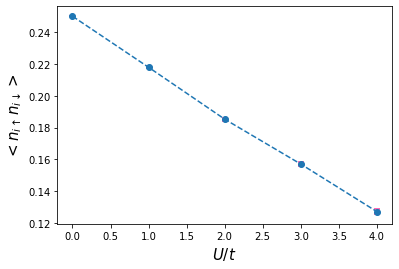

In [18]:
plt.errorbar(U_lst,d_rst,d_err,fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$<n_{i\uparrow}n_{i\downarrow}>$',{'size':15})


Text(0, 0.5, '$E_k$')

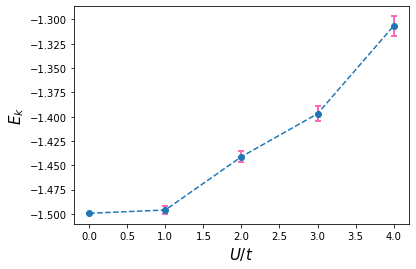

In [19]:
plt.errorbar(U_lst,ek_rst,ek_err,fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$E_k$',{'size':15})

Text(0, 0.5, '$S(\\pi,\\pi)/L^2$')

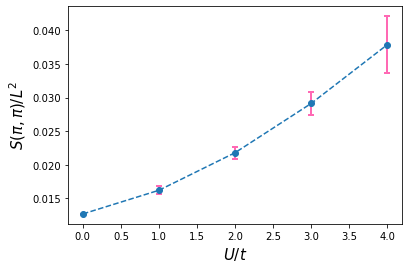

In [20]:
plt.errorbar(U_lst,np.array(spipi_rst)/16,np.array(spipi_err)/16,fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$S(\pi,\pi)/L^2$',{'size':15})

S(pi,pi): 0.2030411835488639


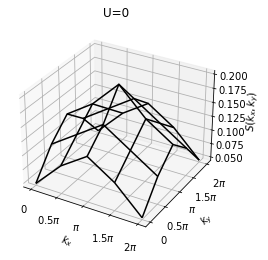

In [45]:
X, Y = np.meshgrid(kx_lst, ky_lst)
Z = skk_rst[0]
print('S(pi,pi):',Z[2][2])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('U=0')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$S(k_x,k_y)$')

index_ls = ['0','$0.5\pi$','$\pi$','$1.5\pi$','$2\pi$']
plt.xticks(kx_lst,index_ls)
plt.yticks(ky_lst,index_ls)

plt.show()

S(pi,pi): 0.2593695622212276


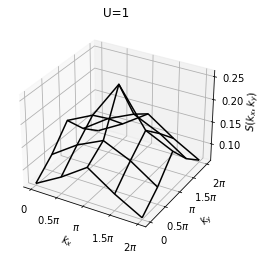

In [46]:
X, Y = np.meshgrid(kx_lst, ky_lst)
Z = skk_rst[1]
print('S(pi,pi):',Z[2][2])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('U=1')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$S(k_x,k_y)$')
index_ls = ['0','$0.5\pi$','$\pi$','$1.5\pi$','$2\pi$']
plt.xticks(kx_lst,index_ls)
plt.yticks(ky_lst,index_ls)
plt.show()

S(pi,pi): 0.34876606402795085


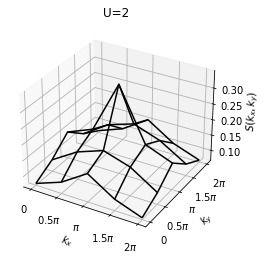

In [53]:
X, Y = np.meshgrid(kx_lst, ky_lst)
Z = skk_rst[2]
print('S(pi,pi):',Z[2][2])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('U=2')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$S(k_x,k_y)$')
index_ls = ['0','$0.5\pi$','$\pi$','$1.5\pi$','$2\pi$']
plt.xticks(kx_lst,index_ls)
plt.yticks(ky_lst,index_ls)
plt.show()

S(pi,pi): 0.46597577496854503


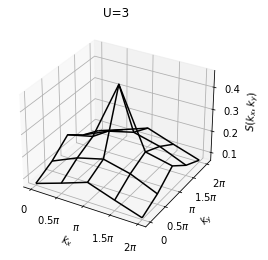

In [48]:
X, Y = np.meshgrid(kx_lst, ky_lst)
Z = skk_rst[3]
print('S(pi,pi):',Z[2][2])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('U=3')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$S(k_x,k_y)$')
x_major_locator=MultipleLocator(np.pi/2)
y_major_locator=MultipleLocator(np.pi/2)
index_ls = ['0','$0.5\pi$','$\pi$','$1.5\pi$','$2\pi$']
plt.xticks(kx_lst,index_ls)
plt.yticks(ky_lst,index_ls)
plt.show()

S(pi,pi): 0.6058308348765937


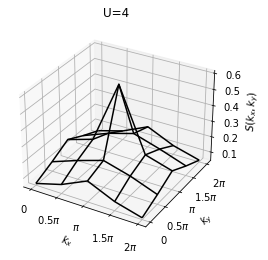

In [49]:
X, Y = np.meshgrid(kx_lst, ky_lst)
Z = skk_rst[4]
print('S(pi,pi):',Z[2][2])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('U=4')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_zlabel('$S(k_x,k_y)$')
index_ls = ['0','$0.5\pi$','$\pi$','$1.5\pi$','$2\pi$']
plt.xticks(kx_lst,index_ls)
plt.yticks(ky_lst,index_ls)
plt.show()

### Benchmark

Here are some papers for benchmark.

[Note for UCAS Summer School by Dr. Xiaoyan Xu](http://ziyangmeng.iphy.ac.cn/files/teaching/SummerSchoolSimpleDQMCnoteXYX201608.pdf),

[PhysRevB.80.075116](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.80.075116).
